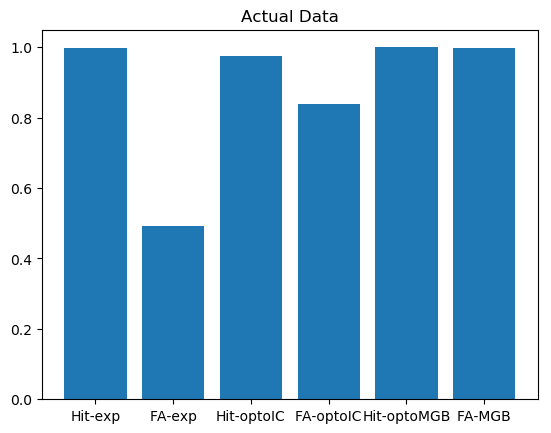

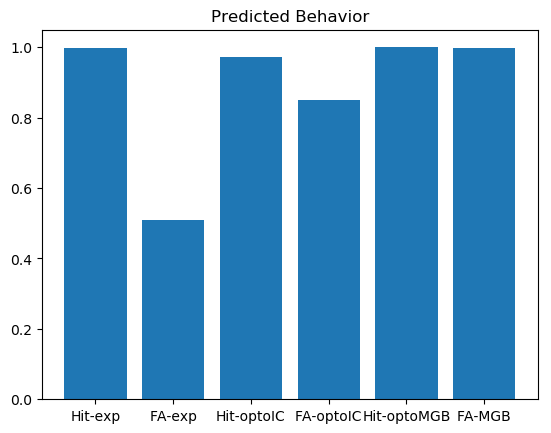

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def four_param_model(x): # IC variance, MGB gain, criteria (no light), criteria (light)
    ICvar = x[0]
    MGBgain = x[1]
    cri = x[2]
    cri_opto = x[3]
    IC = build_distribution(2, ICvar, 0, ICvar)
    MGB = build_distribution(2, ICvar / MGBgain, 0, ICvar / MGBgain)

    expert = apply_criteria(MGB, cri)
    opto_IC = apply_criteria(IC, cri_opto)
    opto_MGB = apply_criteria(MGB, cri_opto)

    return np.array([expert['hit'], expert['fa'], opto_IC['hit'], opto_IC['fa'], opto_MGB['hit'], opto_MGB['fa']])

def build_distribution(t_mean, t_std, f_mean, f_std):
    num_stimuli = 10000
    target_strength = np.random.normal(t_mean, t_std, num_stimuli // 2)
    foil_strength = np.random.normal(f_mean, f_std, num_stimuli // 2)
    
    stimuli = np.concatenate((target_strength, foil_strength))
    label = np.concatenate((np.ones(num_stimuli // 2, dtype=bool), np.zeros(num_stimuli // 2, dtype=bool)))

    return {
        'target': target_strength,
        'foil': foil_strength,
        'stimuli': stimuli,
        'label': label
    }

def my_error(x, y):
    return np.sum((y - four_param_model(x)) ** 2)

def apply_criteria(distribution, criterion):
    hits = np.mean(distribution['target'] > criterion)
    false_alarms = np.mean(distribution['foil'] > criterion)
    return {'hit': hits, 'fa': false_alarms}

# Initial parameters
initial_guess = np.array([2, 2, 0, -2]) # IC variance, MGB gain, criteria (no light), criteria (light)
y = np.array([0.9, 0.1, 0.9, 0.9, 0.6, 0.4])

out = four_param_model(initial_guess) # Actual Data
plt.figure()
plt.bar(range(1, 7), out)
plt.title('Actual Data')
plt.xticks(range(1, 7), ['Hit-exp', 'FA-exp', 'Hit-optoIC', 'FA-optoIC', 'Hit-optoMGB', 'FA-MGB'])
plt.show()

# Minimize the error function
result = minimize(my_error, initial_guess, args=(y,), bounds=[(1e-6, 100), (1e-6, 100), (-100, 100), (-100, 100)])
pred_behav = four_param_model(result.x) # Predicted Behavior
plt.figure()
plt.bar(range(1, 7), pred_behav)
plt.title('Predicted Behavior')
plt.xticks(range(1, 7), ['Hit-exp', 'FA-exp', 'Hit-optoIC', 'FA-optoIC', 'Hit-optoMGB', 'FA-MGB'])
plt.show()